# Investigating the feasibility of building a model to predict terminal category membership

Created by: Grace Patlewicz<br>
Date: 13 May 2024<br>
This notebook investigates the potential of building a ML model to predict terminal category membership in lieu of having to recluster each time.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
processed_dir = TOP + 'data/processed/'
figures_dir = TOP + 'reports/figures/'

In [3]:
import sys

In [4]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [5]:
from model_functions import *

In [7]:
df = pd.read_excel(interim_dir+'final_revised_universe_wmappingdict_130524.xlsx', index_col = [0])

In [8]:
df.shape

(15525, 148)

In [9]:
from sklearn.model_selection import cross_validate,KFold,ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
from sklearn.metrics import auc, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display = 'diagram')

In [10]:
data = mk_fp(df)

In [11]:
data.shape

(15525, 1024)

In [12]:
data.head()

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_1014,mrgn_1015,mrgn_1016,mrgn_1017,mrgn_1018,mrgn_1019,mrgn_1020,mrgn_1021,mrgn_1022,mrgn_1023
IROQAHVXXUQBOS-UHFFFAOYSA-N,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
DTXSID90897582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID90896257,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
DTXSID90896196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
DTXSID90896095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
df['group_str']=[str(e) for e in df['group'] ]

In [15]:
df1 = df.set_index('dtxsid')
y1 = df1[['group_str', 'category', 'chain_length']]

In [16]:
df2 = pd.concat([data, y1], axis = 1)

In [17]:
df2 = df2.sample(frac = 1)

In [18]:
df2

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_1017,mrgn_1018,mrgn_1019,mrgn_1020,mrgn_1021,mrgn_1022,mrgn_1023,group_str,category,chain_length
JPPJOAHAMIEZOL-UHFFFAOYSA-N,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"('Polyfluoroalkyl acids', 'lt7', 1.0, nan)",Polyfluoroalkyl acids,3
DTXSID101348517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"('Aromatic PFASs', 'gte7', nan, nan)",Aromatic PFASs,8
KJKWMBVBKNPQKW-UHFFFAOYSA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,"('PolyFCA derivatives', 'gte7', nan, nan)",PolyFCA derivatives,18
DTXSID90897047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"('Aromatic PFASs', 'lt7', 2.0, 2.0)",Aromatic PFASs,4
DTXSID001334004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"('HFCs', 'lt7', 3.0, nan)",HFCs,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID601348067,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"('Aromatic PFASs', 'lt7', 2.0, 5.0)",Aromatic PFASs,4
DTXSID20382618,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,"('n:2 fluorotelomer-based substances', 'gte7',...",n:2 fluorotelomer-based substances,7
FJDLHPBPLONXQE-UHFFFAOYSA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,"('PFAA precursors', 'lt7', 3.0, 1.0)",PFAA precursors,6
DTXSID30931595,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,"('Polyfluoroalkyl acids, cyclic', 'lt7', 5.0, ...","Polyfluoroalkyl acids, cyclic",2


In [19]:
from collections import Counter

In [20]:
df2['group_str'].value_counts()

('Aromatic PFASs', 'lt7', 2.0, 5.0)            1238
('PASF-based substances', 'gte7', nan, nan)     770
('PASF-based substances', 'lt7', nan, nan)      697
('Aromatic PFASs', 'lt7', 2.0, 2.0)             592
('Aromatic PFASs', 'gte7', nan, nan)            584
                                               ... 
('Other PFASs, cyclic', 'gte7', 2.0, nan)         4
('Other PFASs, cyclic', 'gte7', 1.0, nan)         2
('Other PFASs, cyclic', 'gte7', 3.0, nan)         2
('unclassified', 'lt7', 2.0, 2.0)                 2
('PFAAs, cyclic', 'gte7', nan, nan)               1
Name: group_str, Length: 128, dtype: int64

In [21]:
counts = Counter([molecule for molecule in df2['group_str']])

In [22]:
len( [group for group in counts if counts[group]>=10])

117

In [23]:
small_groups = [group for group in counts if counts[group]<10]

In [24]:
len(small_groups)

11

In [25]:
df2['group'] = df2['group_str'].apply(lambda x: 'misc_category' if x in small_groups else x)

In [26]:
#df2.group.value_counts().reset_index()[df2.group.value_counts().reset_index()['group'] <50]

In [27]:
cats = set(df2['group'].sort_values().tolist())

In [28]:
my_dict = {}
sorted_cats = sorted(cats)  # Sort the categories

for i, e in enumerate(sorted_cats, 1):
    a = f'Category{i}'
    my_dict[e] = a
    

In [29]:
#my_dict

In [30]:
df2['terminal_category'] = df2['group'].replace(my_dict)

In [31]:
df2.terminal_category.value_counts()

Category7      1238
Category30      770
Category31      697
Category4       592
Category1       584
               ... 
Category61       12
Category115      11
Category81       11
Category104      10
Category102      10
Name: terminal_category, Length: 118, dtype: int64

In [32]:
y = df2['terminal_category']

In [33]:
X = df2.drop(['group_str', 'group', 'terminal_category'], axis = 1)

In [34]:
X.shape

(15525, 1026)

In [38]:
X.iloc[:,-3:]

,mrgn_1023,category,chain_length
JPPJOAHAMIEZOL-UHFFFAOYSA-N,0,Polyfluoroalkyl acids,3
DTXSID101348517,0,Aromatic PFASs,8
KJKWMBVBKNPQKW-UHFFFAOYSA-N,1,PolyFCA derivatives,18
DTXSID90897047,0,Aromatic PFASs,4
DTXSID001334004,0,HFCs,3
...,...,...,...
DTXSID601348067,0,Aromatic PFASs,4
DTXSID20382618,1,n:2 fluorotelomer-based substances,7
FJDLHPBPLONXQE-UHFFFAOYSA-N,1,PFAA precursors,6
DTXSID30931595,0,"Polyfluoroalkyl acids, cyclic",2


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

In [40]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [41]:
from sklearn import set_config
set_config(display='diagram')

In [43]:
X['category'] = X['category'].astype('category')

In [48]:
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

numerical_columns_selector = selector(dtype_include=int)
categorical_columns_selector = selector(dtype_include='category')

In [49]:
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [51]:
numerical_columns[-1]

'chain_length'

In [53]:
from sklearn.preprocessing import OrdinalEncoder

In [54]:
categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)

In [55]:
numerical_pipe = StandardScaler()

In [56]:
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=True,
)

In [57]:
rfc = RandomForestClassifier(n_estimators = 100, max_samples = 0.66, random_state = 42)

In [58]:
from sklearn.pipeline import Pipeline

In [59]:
pipe = Pipeline([('preprocessing', preprocessing), ('model',rfc)])

In [60]:
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['category']),
                                                 ('num', StandardScaler(),
                                                  ['mrgn_0', 'mrgn_1', 'mrgn_2',
                                                   'mrgn_3', 'mrgn_4', 'mrgn_5',
                                                   'mrgn_6', 'mrgn_7', 'mrgn_8',
                                                   'mrgn_9', 'mrgn_10',
                                                   'mrgn_11', 'mrgn_12',
                                                   'mrgn_13', 'mrgn_14',
                                                   'mrgn_15', 'mrgn_16',
                                                   'mrgn_17', 'mrgn_18',
                                                   'mrgn_19', 'mrgn_20',
                                                   'mrgn_21', 'mrgn_22',
                                                   'mrgn_23', 'mrgn_24',
                                                   'mrgn_25', 'mrgn_26',
                                                   'mrgn_27', 'mrgn_28',
                                                   'mrgn_29', ...])])),
                ('model',
                 RandomForestClassifier(max_samples=0.66, random_state=42))])

In [62]:
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

In [63]:
scorer = make_scorer(balanced_accuracy_score)

Dummy classifier

In [64]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [65]:
pipe_dummy = Pipeline([('preprocessing', preprocessing), ('dummy',dummy_clf)])

In [66]:
result_dummy = cross_validate(pipe_dummy, X_train, y_train, cv=cv, scoring = scorer )

In [67]:
result_dummy

{'fit_time': array([0.56431746, 0.56328368, 0.52125025, 0.51991749, 0.53673458]),
 'score_time': array([0.04972577, 0.04112148, 0.0422771 , 0.0404079 , 0.05919266]),
 'test_score': array([0.00847458, 0.00847458, 0.00847458, 0.00847458, 0.00847458])}

RF defaults

In [68]:
cv_results = cross_validate(pipe, X_train, y_train , cv=cv, scoring = scorer, return_train_score = True)

In [69]:
cv_results

{'fit_time': array([6.17436099, 5.84973717, 5.76629639, 5.55578375, 5.66930532]),
 'score_time': array([0.23130083, 0.19121575, 0.20170665, 0.19838977, 0.21106482]),
 'test_score': array([0.80020284, 0.79430792, 0.81508945, 0.80433301, 0.79121843]),
 'train_score': array([0.99865258, 0.99991926, 0.99845721, 0.99683073, 0.99866576])}

In [70]:
print(cv_results['test_score'].mean(), cv_results['test_score'].std())

0.8010303329965021 0.008375145892453268


In [71]:
print(' 5 fold CV mean BA score = {} with 10 fold CV std = {}'.format(cv_results['test_score'].mean(), cv_results['test_score'].std()))


 5 fold CV mean BA score = 0.8010303329965021 with 10 fold CV std = 0.008375145892453268


In [72]:
cv_results = pd.DataFrame(cv_results)

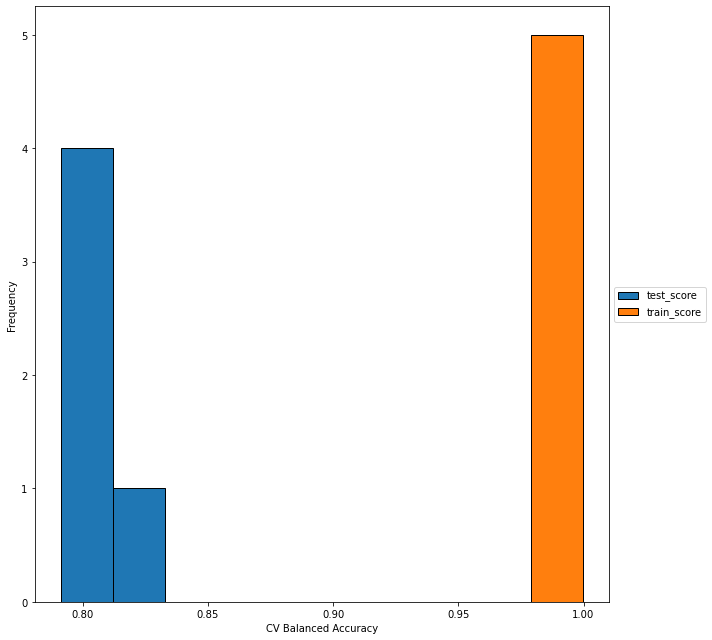

In [73]:
cv_results[['test_score', 'train_score']].plot.hist(edgecolor = 'black', figsize = (10,9))
plt.xlabel('CV Balanced Accuracy')
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.tight_layout()

In [74]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [79]:
pipe[1]

RandomForestClassifier(max_samples=0.66, random_state=42)

In [93]:
param_grid = {
    'clf__n_estimators': [100, 200, 300, 400],
    'clf__max_features': ['sqrt', 'log2',],
    'clf__max_depth': [None, 10, 20],
    'clf__max_samples':[0.66],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__class_weight': ['balanced','balanced_subsample', None],
    'clf__criterion' :['gini', 'entropy']
}

In [94]:
pipe_1 = Pipeline([('preprocessing', preprocessing), ('clf',RandomForestClassifier(random_state = 42))])

In [95]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [96]:
random_search = RandomizedSearchCV(estimator=pipe_1, param_distributions=param_grid, n_iter=50,
                                   scoring=make_scorer(balanced_accuracy_score), n_jobs=-1, cv=cv, random_state=42)

In [97]:
# Fit the random search to your data
random_search.fit(X_train, y_train)  # X: features, y: target variable


/home/gpatlewi/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OrdinalEncoder(encoded_missing_value=-1,
                                                                                              handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['category']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['mrgn_0',
                                                                                'mrgn_1',
                                                                                'mrgn_2',
                                                                                'mrgn_3',
                                                                                'mrgn_4',
                                                                                'mrgn_5',
                                                                                'mr...
                   param_distributions={'clf__class_weight': ['balanced',
                                                              'balanced_subsample',
                                                              None],
                                        'clf__criterion': ['gini', 'entropy'],
                                        'clf__max_depth': [None, 10, 20],
                                        'clf__max_features': ['sqrt', 'log2'],
                                        'clf__max_samples': [0.66],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [2, 5, 10],
                                        'clf__n_estimators': [100, 200, 300,
                                                              400]},
                   random_state=42,
                   scoring=make_scorer(balanced_accuracy_score, response_method='predict'))

In [99]:
random_search.best_params_

{'clf__n_estimators': 400,
 'clf__min_samples_split': 2,
 'clf__min_samples_leaf': 2,
 'clf__max_samples': 0.66,
 'clf__max_features': 'sqrt',
 'clf__max_depth': None,
 'clf__criterion': 'gini',
 'clf__class_weight': 'balanced_subsample'}

In [100]:
pipe_rm = Pipeline([('preprocessing', preprocessing), ('clf',RandomForestClassifier(n_estimators= 400, min_samples_split= 2,
 min_samples_leaf= 2, max_features='sqrt', max_depth= None, criterion = 'gini', max_samples = 0.66, class_weight= 'balanced_subsample',random_state = 42))])

In [101]:
cv_results = cross_validate(pipe_rm, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring = make_scorer(balanced_accuracy_score), return_estimator=True, n_jobs=-1,return_train_score = True)

In [102]:
print(cv_results['test_score'].mean(), cv_results['test_score'].std())

0.8418358747849709 0.005750718159982279


In [104]:
cv_results['test_score']

array([0.83935237, 0.84359964, 0.83449873, 0.8517713 , 0.83995733])

In [105]:
pipe_rm.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['category']),
                                                 ('num', StandardScaler(),
                                                  ['mrgn_0', 'mrgn_1', 'mrgn_2',
                                                   'mrgn_3', 'mrgn_4', 'mrgn_5',
                                                   'mrgn_6', 'mrgn_7', 'mrgn_8',
                                                   'mrgn_9', 'mrgn_10',
                                                   'mrgn_11', 'mrgn_12',
                                                   'mrgn_13', 'mrgn_14',
                                                   'mrgn_15', 'mrgn_16',
                                                   'mrgn_17', 'mrgn_18',
                                                   'mrgn_19', 'mrgn_20',
                                                   'mrgn_21', 'mrgn_22',
                                                   'mrgn_23', 'mrgn_24',
                                                   'mrgn_25', 'mrgn_26',
                                                   'mrgn_27', 'mrgn_28',
                                                   'mrgn_29', ...])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_samples=0.66, min_samples_leaf=2,
                                        n_estimators=400, random_state=42))])

In [106]:
preds = pipe_rm.predict(X_test)

In [107]:
balanced_accuracy_score(y_test, preds)

0.8594106091582114

In [108]:
from sklearn.metrics import recall_score, accuracy_score
unique_classes = set(y_test)

# Initialize a dictionary to store the balanced accuracy scores for each class
balanced_accuracy_scores = {}
recall_scores = {}
# Compute balanced accuracy for each class
for cls in unique_classes:
    # Create binary labels for the current class
    y_true_cls = [1 if y == cls else 0 for y in y_test]
    y_pred_cls = [1 if y == cls else 0 for y in preds]
    
    # Compute recall (sensitivity) for the current class
    recall = recall_score(y_true_cls, y_pred_cls)
    
    # Compute specificity (true negative rate) for the current class
    tn = sum(1 for true, pred in zip(y_true_cls, y_pred_cls) if true == pred == 0)
    fp = sum(1 for true, pred in zip(y_true_cls, y_pred_cls) if true == 0 and pred == 1)
    specificity = tn / (tn + fp)
    
    # Compute balanced accuracy for the current class
    balanced_accuracy = (recall + specificity) / 2
    
    # Store the balanced accuracy score for the current class
    balanced_accuracy_scores[cls] = balanced_accuracy
    recall_scores [cls] = recall


In [109]:
recall_scores['Category1']

0.9829059829059829

In [110]:
from sklearn.metrics import auc, matthews_corrcoef
from sklearn.metrics import confusion_matrix, classification_report


In [111]:
matthews_corrcoef(y_test, preds)

0.8885351442320409

In [112]:
confusion_matrix(y_test, preds)

array([[115,   1,   0, ...,   0,   0,   0],
       [  0,  37,   0, ...,   0,   0,   0],
       [  0,   0,  11, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  44,   0,   0],
       [  1,   0,   0, ...,   0,   3,   0],
       [  0,   0,   0, ...,   0,   0,   2]])

In [113]:
report = (classification_report(y_test, preds))

In [115]:
#report

In [116]:
report = report.split('\n')

In [117]:
test = pd.DataFrame(report)

In [118]:
test

,0
0,precision recall f1-score ...
1,
2,Category1 0.96 0.98 0.97 ...
3,Category10 0.84 0.93 0.88 ...
4,Category100 0.85 0.92 0.88 ...
...,...
120,
121,accuracy 0.89 ...
122,macro avg 0.84 0.86 0.84 ...
123,weighted avg 0.90 0.89 0.89 ...


In [119]:
result_df = test[0].str.split(expand=True)

In [120]:
 result_df.iloc[0,:].tolist()

['precision', 'recall', 'f1-score', 'support', None, None]

In [121]:
result_df.columns = ['Category', 'precision', 'recall', 'f1-score', 'support', 'untitled']

In [122]:
result_df = result_df.iloc[2:,:]

In [123]:
result_df.to_csv(external_dir+'cr2.csv')

In [126]:
report_df = pd.read_csv(external_dir+'cr2.csv', index_col = [0])

In [128]:
report_df.drop(['untitled'], axis = 1, inplace = True)

In [131]:
report_df = report_df.iloc[:-1, :]

In [132]:
reverse_dict = {v:k for k,v in my_dict.items()}

In [133]:
report_df['terminal_category'] = report_df['Category'].replace(reverse_dict)

/tmp/ipykernel_3299165/4033952111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_df['terminal_category'] = report_df['Category'].replace(reverse_dict)


In [135]:
#report_df.to_csv(external_dir+'classification_performance_140524.csv')

In [136]:
report_df =  pd.merge(report_df, pd.DataFrame(list(balanced_accuracy_scores.items()), columns = ['Category', 'BA']), on = 'Category', how = 'left' )

In [145]:
report_df.sort_values(by = 'BA', ascending = False).head(10)

,Category,precision,recall,f1-score,support,terminal_category,BA
11,Category109,1.0,1.0,1.0,3.0,"('others, cyclic', 'lt7', 3.0, 4.0)",1.0
95,Category79,1.0,1.0,1.0,3.0,"('Polyfluoroalkyl acids, cyclic', 'lt7', 1.0, ...",1.0
107,Category9,1.0,1.0,1.0,12.0,"('Aromatic PFASs', 'lt7', 4.0, 1.0)",1.0
101,Category84,1.0,1.0,1.0,4.0,"('Polyfluoroalkyl acids, cyclic', 'lt7', 5.0, ...",1.0
4,Category102,1.0,1.0,1.0,2.0,"('others, cyclic', 'lt7', 2.0, 1.0)",1.0
63,Category5,1.0,1.0,1.0,18.0,"('Aromatic PFASs', 'lt7', 2.0, 3.0)",1.0
75,Category60,1.0,1.0,1.0,3.0,"('PFAAs, cyclic', 'lt7', 2.0, nan)",1.0
60,Category47,1.0,1.0,1.0,4.0,"('PFAA precursors, cyclic', 'lt7', 1.0, 1.0)",1.0
97,Category80,1.0,1.0,1.0,5.0,"('Polyfluoroalkyl acids, cyclic', 'lt7', 2.0, ...",1.0
35,Category24,1.0,1.0,1.0,5.0,"('Other PFASs, cyclic', 'lt7', 1.0, 1.0)",1.0


In [146]:
report_df.sort_values(by = 'BA', ascending = False).tail(10)

,Category,precision,recall,f1-score,support,terminal_category,BA
39,Category28,0.67,0.40,0.50,5.0,"('Other PFASs, cyclic', 'lt7', 3.0, 2.0)",0.699839
21,Category118,0.80,0.40,0.53,10.0,misc_category,0.699838
14,Category111,0.20,0.33,0.25,3.0,"('unclassified', 'lt7', 1.0, 2.0)",0.666022
15,Category112,0.50,0.31,0.38,13.0,"('unclassified', 'lt7', 1.0, 3.0)",0.653199
19,Category116,1.00,0.25,0.40,4.0,"('unclassified', 'lt7', 3.0, 3.0)",0.625000
17,Category114,0.20,0.25,0.22,4.0,"('unclassified', 'lt7', 3.0, 1.0)",0.624355
16,Category113,0.00,0.00,0.00,3.0,"('unclassified', 'lt7', 2.0, 3.0)",0.499516
118,accuracy,NaN,NaN,0.89,3105.0,accuracy,NaN
119,macro_avg,0.84,0.86,0.84,3105.0,macro_avg,NaN
120,weighted_avg,0.90,0.89,0.89,3105.0,weighted_avg,NaN


In [138]:
report_df1 = report_df.iloc[:-3, :]

In [142]:
report_df1.to_csv(external_dir+'classification_performance_150524.csv')

In [143]:
report_df2 = report_df1.iloc[:118,:].melt(id_vars=['terminal_category'], value_vars=['recall','BA'], var_name='metric', value_name='value')

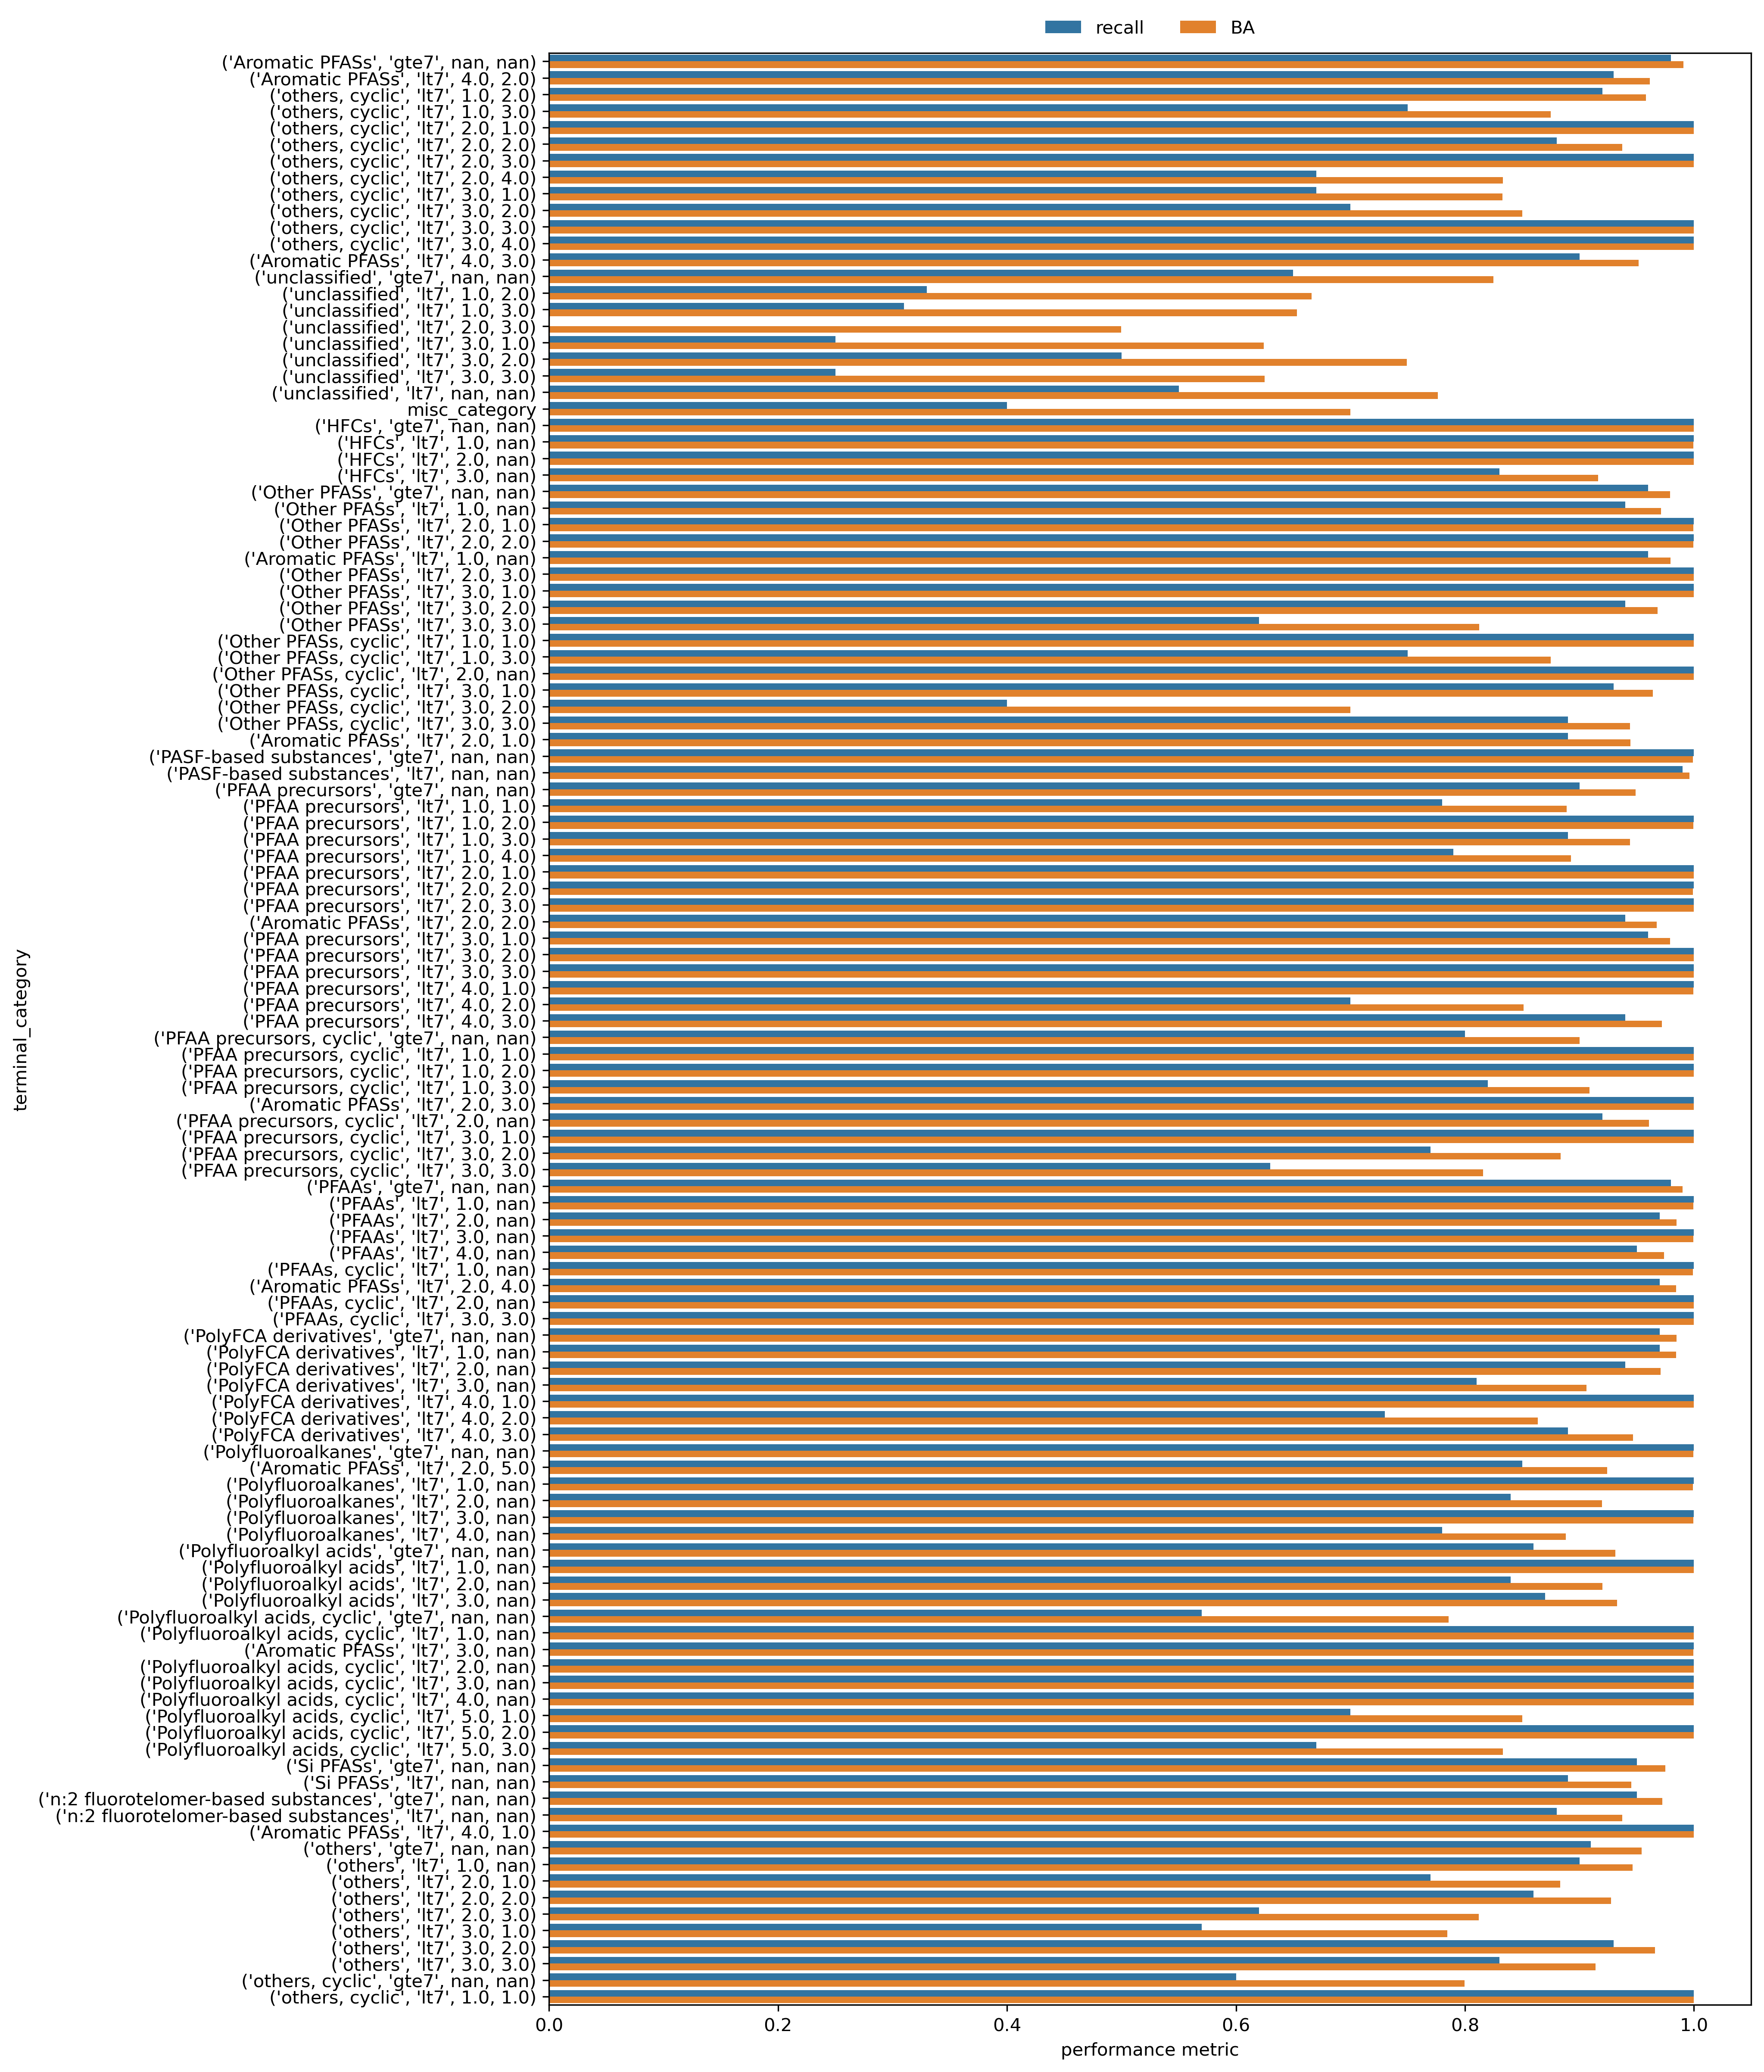

In [144]:
fig,ax = plt.subplots(figsize=(12, 20), dpi=300)
p = sns.barplot(ax=ax, data=report_df2, y='terminal_category', x='value', hue='metric', orient='h')
sns.move_legend(ax, "lower center",bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False, fontsize=10 )
ax.set_xlabel('performance metric')
fig.savefig(figures_dir+'classification_rfc_150524.png')